# Example on how to use of regenie for single variant analysis of exome data

## Introduction

[Regenie](https://rgcgithub.github.io/regenie/) is a program that performs genome-wide association analysis in very large datases such as the UK Biobank.

## Properties

1. Works with quantitative and binary traits (case-control), including those with unbalanced samples case-control ratio. Supports Firth logistic regression and SPA for binary traits.
2. Uses linear mixed models (LMM) for quantitative traits and generalized LMM (GLMM) for binayr traits, allowing for the inclusion of related individuals. 
3. Offers the advantage of processing multiple phenotypes at the same time. However you should be aware that quantitave or binary traits need to be analyzed separately. Also, the proportion of missing data should be similar for all of the traits analyzed at once, since it can impact predictions. Authors of regenie recommend to analyze traits in groups that have similar missingness patterns with resonably low amount of missingness (<15%).
4. It can handle different types of data (microarray, imputed, exome sequencing) and formats (PLINK:bed/bim/fam, PLINK2:pgen/pvar/psam and BGEN).
5. It is desgined to handle a large number of samples ~500K. Regenie is not appropiate to analyze small samples
6. Integrates covariates into the model.

## Method

Regenie works in two different steps that are independent from each other. 

### Step 1. 

The first step is where it fits the null regression model, for this regenie uses a subset of genetic markers that capture a good proportion of the phenotype variance that is attributable to genetic effects

- Level 0: Ridge regression applied to block of SNPs to reduce dimensions
- Level 1: Linear or logistic ridge regressions within cross validation scheme

### Step 2.

A larger set of genetic markers is used to test for association, using a linear or logistic regression, with the traits conditional upon the prediction from the regression model on step 1. This is done by using the Leave One Chromosome Out (LOCO) scheme to avoid proximal contamination. 

## Toy dataset

For this exercise we will use data from 1000G pubicly available database.The populations in the dataset are GBR=82, FIN=99 and TSI=104.

Please note that this is only an example dataset for real life applications a much larger sample size is necessary. Also due to the use of different populations the use of principal components may be necessary to avoid increased type I error. 

```
1000G.EUR.fam
1000G.EUR.bim
1000G.EUR.bed
```


In [ ]:
# Read in subset of individuals
library(dplyr)
EUR_subset_fam <- read.table('~/1000G_data/1000G.EUR.fam',  head=F)
colnames(EUR_subset_fam) <- c("FID", "IID", "mother", "father", "sex", "phenotype")

In [13]:
dim(EUR_subset_fam)

[1] 489   6

## Create phenoFile

For the 1000G data there is not phenotype data available. Therefore we have create a  disease x phenotype by randomly assigning study subjects as cases and controls. Therefore the data is generated under the null of no association. 

In [14]:
EUR_subset_fam$x <- sample(c(0,1), replace=TRUE, size=489)

In [15]:
EUR_subset_fam$sex <- sample(c(0,1), replace=TRUE, size=489)

In [16]:
pheno <- EUR_subset_fam %>%
    select('FID', "IID", "sex", "x")
head(pheno)
write.table(pheno,'~/1000G_data/1000G.EUR.pheno.x', sep="\t",row.names=F, quote=F)

,FID,IID,sex,x
,<fct>,<fct>,<dbl>,<dbl>
1,HG00096,HG00096,1,1
2,HG00097,HG00097,1,0
3,HG00099,HG00099,1,1
4,HG00101,HG00101,1,0
5,HG00102,HG00102,1,1
6,HG00103,HG00103,0,0


In [17]:
length(which(pheno$sex == 0))

[1] 241

In [18]:
all_1KG <-  read.table('~/1000G_data/integrated_call_samples_v3.20200731.ALL.ped', sep="\t",head=T)
head(all_1KG)

,Family.ID,Individual.ID,Paternal.ID,Maternal.ID,Gender,Phenotype,Population,Relationship,Siblings,Second.Order,Third.Order,Children,Other.Comments,phase.3.genotypes,related.genotypes,omni.genotypes,affy_genotypes
,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0,1,0,1,1
2,HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0,1,0,1,1
3,HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0,0,0,1,1
4,HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0,1,0,1,1
5,HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0,1,0,1,1
6,HG00101,HG00101,0,0,1,0,GBR,unrel,0,0,0,0,0,1,0,1,1


In [19]:
group <- all_1KG[all_1KG$Family.ID %in% EUR_subset_fam$FID,]

In [20]:
group %>%                    
  count(Population)

Population,n
<fct>,<int>
FIN,99
GBR,82
TSI,104


## Create pruned genotype files for analyses

In [2]:
module load PLINK/2.0

/home/dmc2245/miniconda3/lib/python3.8/site-packages/sos_notebook/kernel.py:1334: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  msg['msg_id'] = self._parent_header['header']['msg_id']


In [ ]:
plink2 --bfile ~/1000G_data/1000G.EUR --maf 0.01 --geno 0.1 --mind 0.1 --hwe 5e-08 --make-bed --out ~/1000G_data/1000G.EUR.filtered

In [ ]:
plink2 --bfile ~/1000G_data/1000G.EUR.filtered --indep-pairwise 100 10 0.04 --out ~/1000G_data/1000G.EUR.pruned

In [ ]:
plink2 --bfile ~/1000G_data/1000G.EUR.filtered --extract ~/1000G_data/1000G.EUR.pruned.prune.in --make-bed --out ~/1000G_data/1000G.EUR.filtered.pruned

# Create just a pruned file

In [ ]:
plink2 --bfile ~/1000G_data/1000G.EUR --extract ~/1000G_data/1000G.EUR.pruned.prune.in --make-bed --out ~/1000G_data/1000G.EUR.pruned

## Runing the single variant association analysis

**1. Prepare the data**

In this example, we are going to use a subset of genetic markers from the data to fit the null model of step 1. 

This process has been already integrated in the [LMM pipeline](https://github.com/cumc/bioworkflows/blob/master/GWAS/LMM.ipynb) under the `regenie_qc` step. It is recommended to use the data from the genotype array in this step, as it provides better estimates of the phenotype variance. 

Note: make sure you don't have any SNVs with a very low minor allele count (MAC) for the single variant analysis, otherwise regenie will give an error message. 

Let the parameters for the initial quality control be:

- maf_filter=0.01, we will keep only variant with MAF >1%
- geno_filter=0.1, we will remove variants with > 10% genotypes missing
- mind_filter=0.1, we will remove individals with > 10% genotypes missing 
- hwe_filter=5e-08, we will remove variants exceding a p-value for HWE > 5E-08

The output produced in this part consist of two files:

`1000G.EUR.mini.qc_pass.id` and `1000G.EUR.mini.qc_pass.snplist`, these contain the list of individuals and variants to keep in the step 1 of regenie. 

In this MWE we keep n=32,254 variants and n=489 samples that pass our QC filters. 


**2. Fitting the null**

In this step, we will use the genotype file and we will tell regenie which samples and variants to keep based on the results of our QC. 

- bfile=1000G.EUR.filtered.pruned.bed, we will use a subset of the genotyped genetic markers to calculate the predictions. This file has been pruned using a window size of 100, step of 10 and a r^2 of 0.04 as shown in numeral 1.6.
- block_size=1000 this will tell the program in how many "chunks" to divide the genotype file to make predictions

The output produced in this step correspond to: 

- A set of files (depending on the number of phenotypes analyzed) containing genomic predictions for each phenotype from Step 1 `1000G.EUR.pheno_asthma.regenie_1.loco`
- A file called `1000G.EUR.pheno_asthma.regenie_pred.list` listing the locations of the prediction files

**3. Association analysis**

In this step, namely step 2 of regenie, it will perform the single variant association analysis with each of the phenotypes. 

Note: a convenient quality of REGENIE is that step 1 and 2 are decoupled meaning that you can use all of the traits used in step 1 or just a subset of them for the association analysis. Also, you can test the association using array, exomed or imputed variants. 

For this example, we will use our phenotype for disease x with the following parameters:

- trait='bt' Here you define whether your trait is binary of quantitative.
- covarCol=sex In our particular case we will only use sex as covariate. However, if you have more than one you can input them here separeted by comma
- qCovarCol We will leave this variable empty in our analysis, but as above you can give a list of quantitative variables. 
- minMac=5 this flag is used to tell the program which minimum minor allele count (MAC) to use when testing variants, default value is 5. 

Depending on the type of data you are using, there are other useful parameters that you can explore. For example, with imputed data you may want to set the minimum info score to use (`--minINFO`), with quantitative phenotypes you may choose to use an inverse rank normalization (`--apply-rint`), for binary traits you can decide whether to use Firth (`--firth`) or Saddle Point Approximation (`--spa`) corrections 

The output produced in this step corresponds to:

- Summary statistics in a file with `*.regenie` extension, if option `-gz` was used this files will be compressed `*.regenie.gz`

### REGENIE example command
On a minimal working example (MWE) dataset

In [2]:
module load Singularity
sos run ~/project/bioworkflows/GWAS/LMM.ipynb regenie \
    --cwd ~/MWE_regenie/output \
    --bfile ~/MWE_regenie/data/1000G.EUR.pruned.bed \
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile ~/MWE_regenie/data/1000G.EUR.bed \
    --phenoFile ~/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/project/UKBB_GWAS_dev/data/regenie_template.yml\
    --phenoCol x\
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 5 \
    --reverse_log_p \
    --p-filter 1 \
    --label_annotate SNP\
    --container_lmm ~/containers/lmm.sif\
    --container_marp ~/containers/marp.sif\
    -s build

INFO: Running regenie_qc: Select the SNPs and samples to be used based on maf, geno, hwe and mind options
INFO: Step regenie_qc (index=0) is ignored with signature constructed
INFO: regenie_qc output:   /home/dmc2245/MWE_regenie/cache/1000G.EUR.filtered.pruned.qc_pass.id /home/dmc2245/MWE_regenie/cache/1000G.EUR.filtered.pruned.qc_pass.snplist
INFO: Running regenie_1: Run REGENIE step 1: fitting the null
INFO: Step regenie_1 (index=0) is ignored with signature constructed
INFO: regenie_1 output:   /home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie_pred.list
INFO: Running regenie_2: Run REGENIE step 2: association analysis
INFO: Step regenie_2 (index=0) is ignored with signature constructed
INFO: regenie_2 output:   /home/dmc2245/MWE_regenie/cache/1000G.EUR_x.regenie.gz
INFO: Running regenie_3: Merge results and log files
INFO: Step regenie_3 (index=0) is ignored with signature constructed
INFO: regenie_3 output:   /home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.snp_stats.gz /home/

## Using then miniature example

In [ ]:
module load Singularity
sos run ~/project/UKBB_GWAS_dev/workflow/regenie.ipynb regenie:3 \
    --cwd /home/dmc2245/MWE_regenie/output_mini_test \
    --bfile /home/dmc2245/1000G_data/1000G.EUR.filtered.pruned.bed\
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile /home/dmc2245/1000G_data/1000G.EUR.filtered.pruned.bed\
    --phenoFile /home/dmc2245/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/project/UKBB_GWAS_dev/data/regenie_template.yml\
    --phenoCol x \
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 5 \
    --reverse_log_p \
    --p-filter 1 \
    --container_lmm ~/containers/lmm.sif\
    --container_marp ~/containers/marp.sif\
    -s build

> /home/dmc2245/MWE_regenie/output_mini_test/1000G.EUR.pheno_x.regenie.manhattan.png (221.1 KiB):

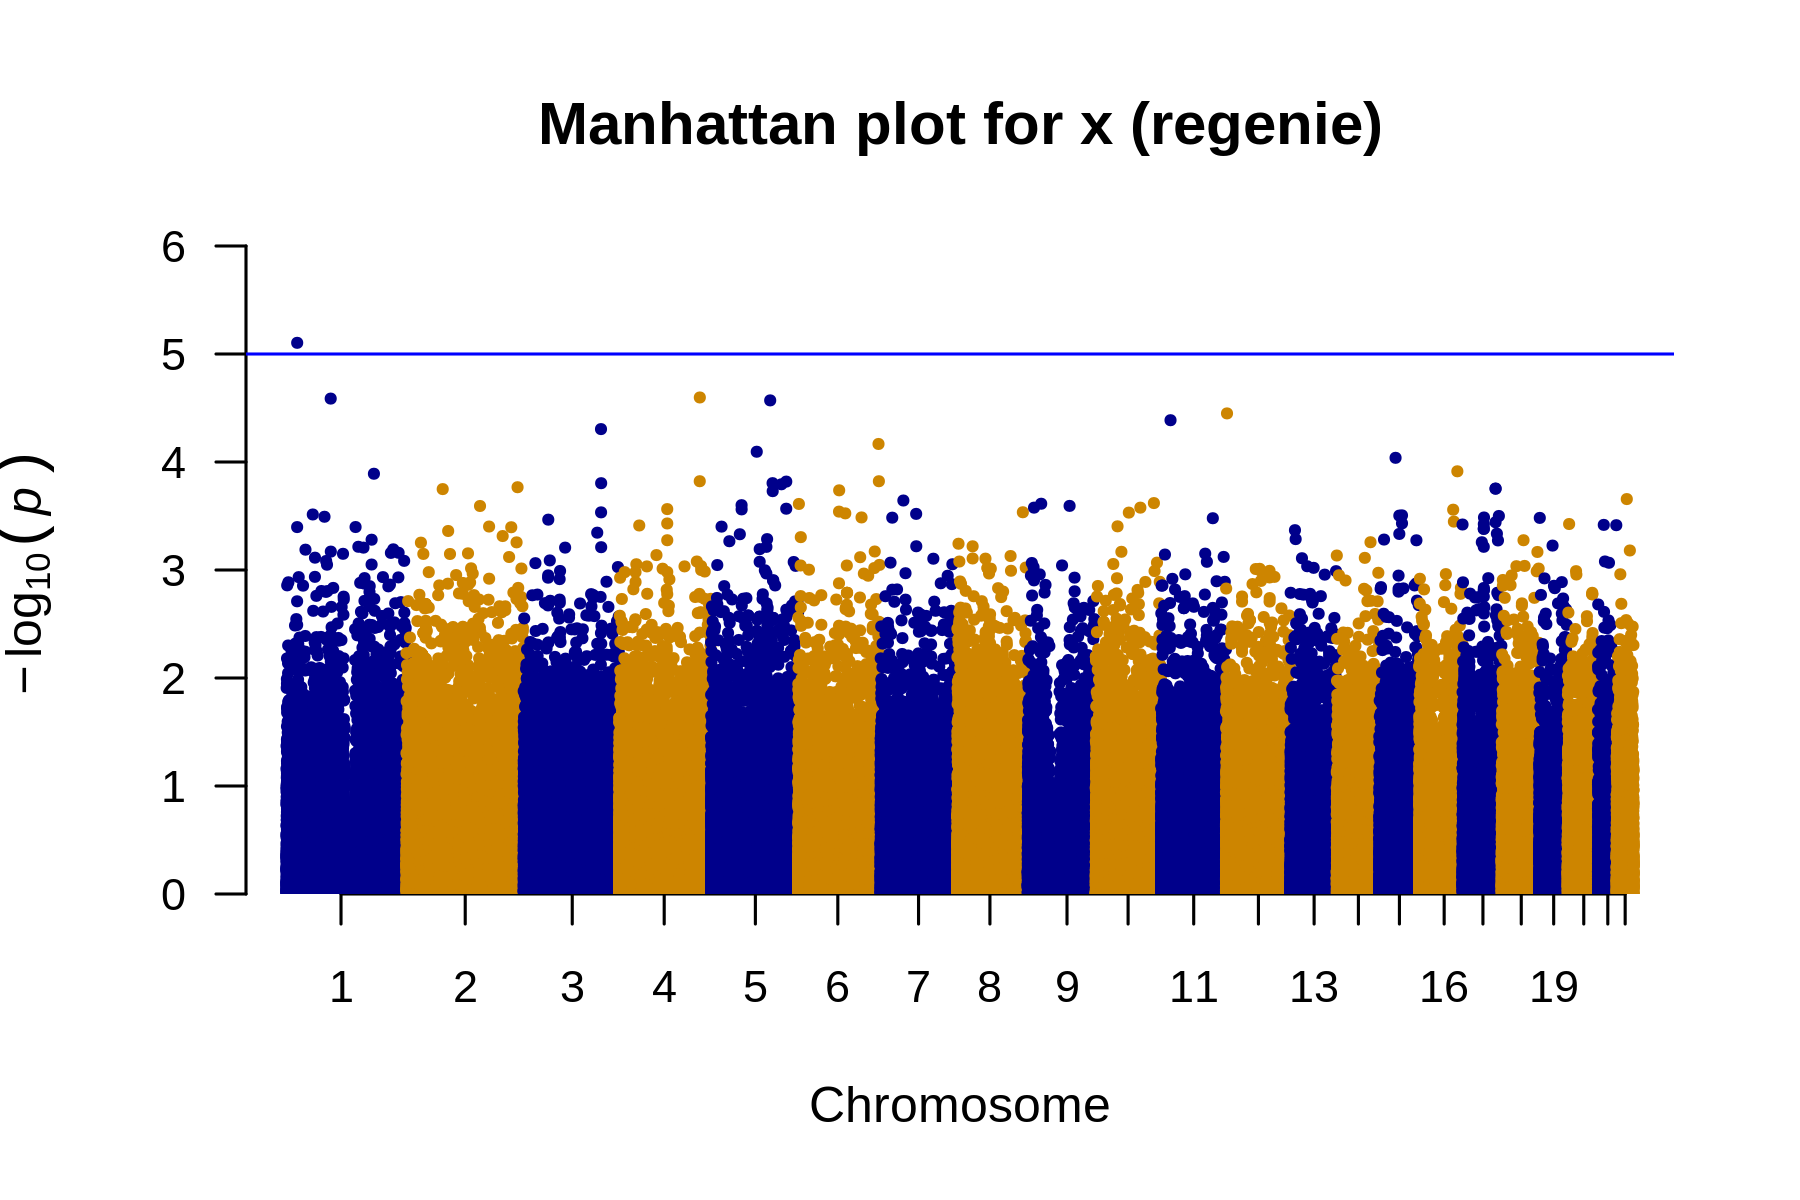

>>> /home/dmc2245/MWE_regenie/output_mini_test/1000G.EUR.pheno_x.regenie.manhattan.png:

bash: /home/dmc2245/MWE_regenie/output_mini_test/1000G.EUR.pheno_x.regenie.manhattan.png: Permission denied



In [1]:
%preview -s png /home/dmc2245/MWE_regenie/output_mini_test/1000G.EUR.pheno_x.regenie.manhattan.png

#### Manhattan plot

> /home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan.png (209.9 KiB):

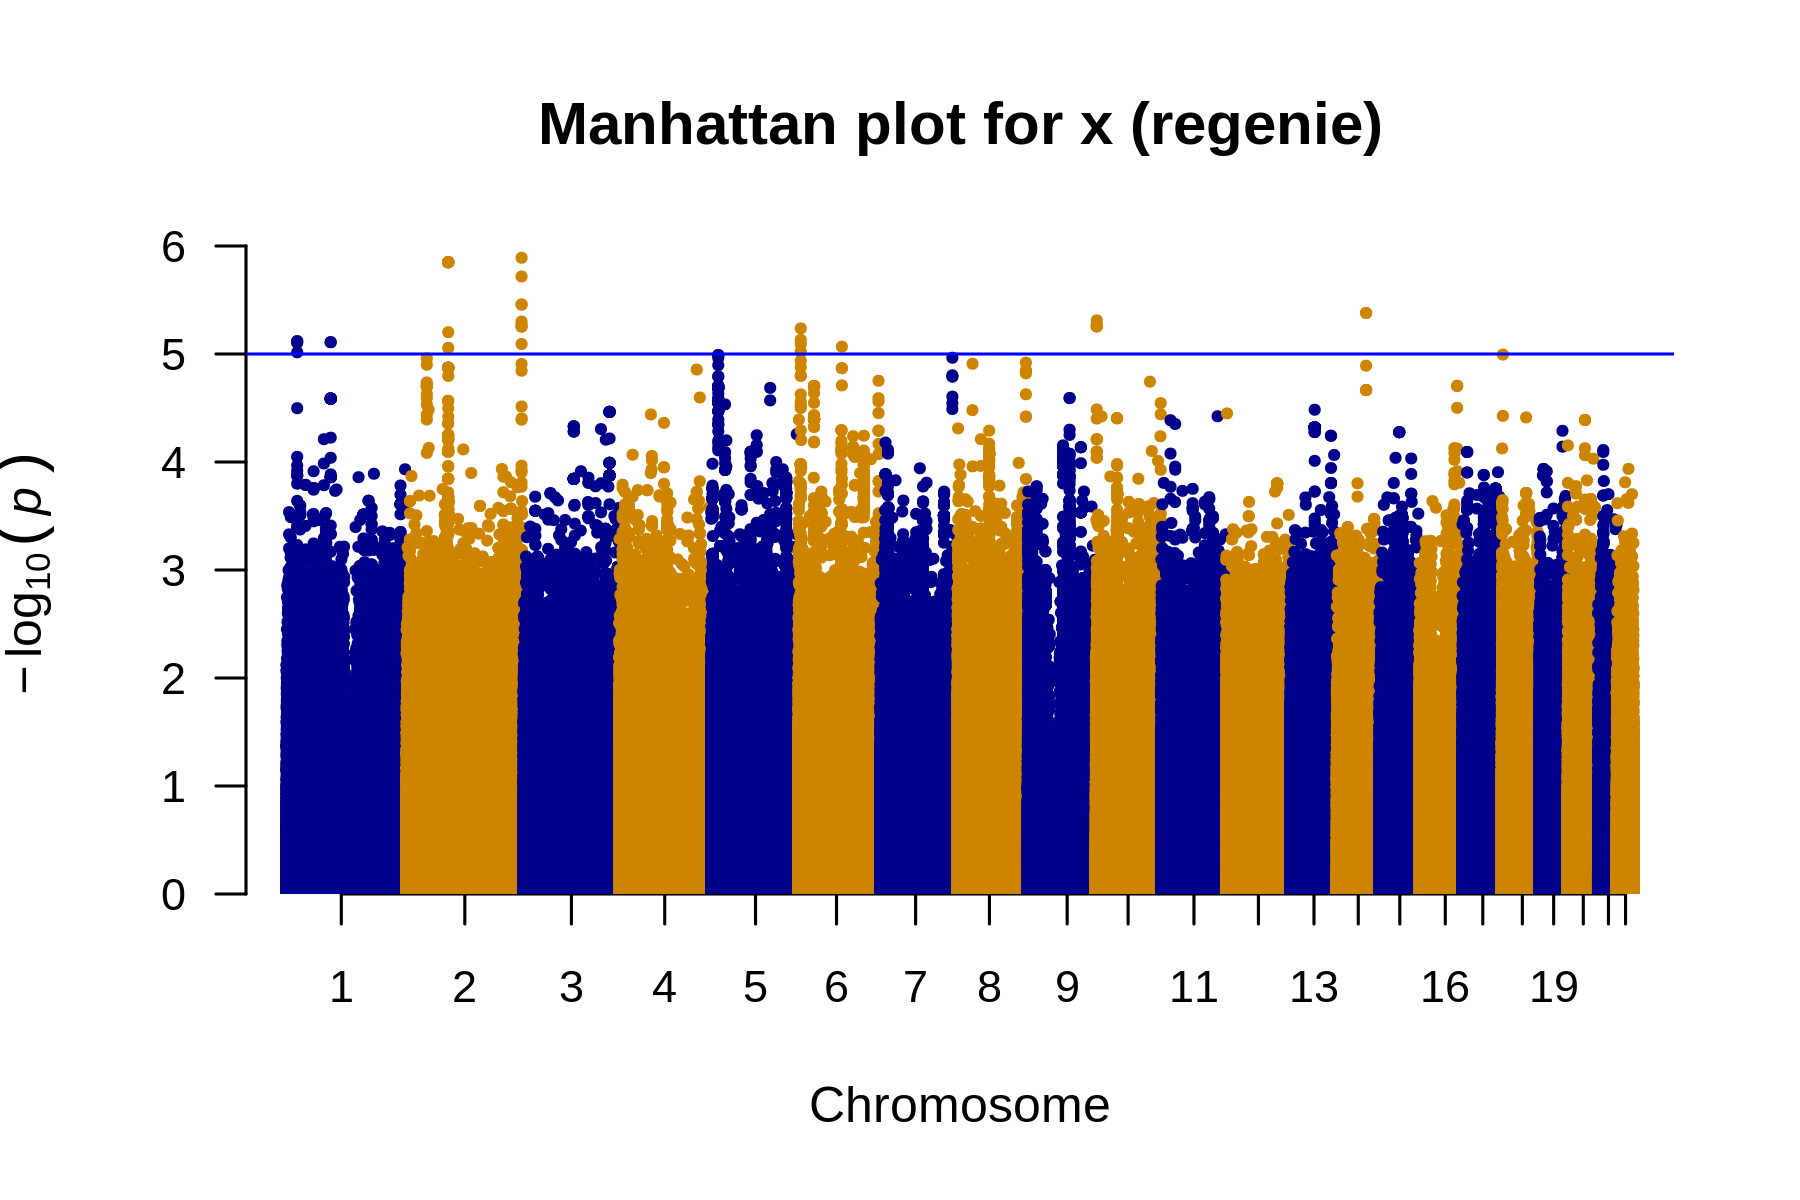

>>> ~/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan.png:

bash: /home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan.png: Permission denied



In [3]:
%preview -s png ~/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan.png

#### Q-Q plot

> /home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.qq.png (77.0 KiB):

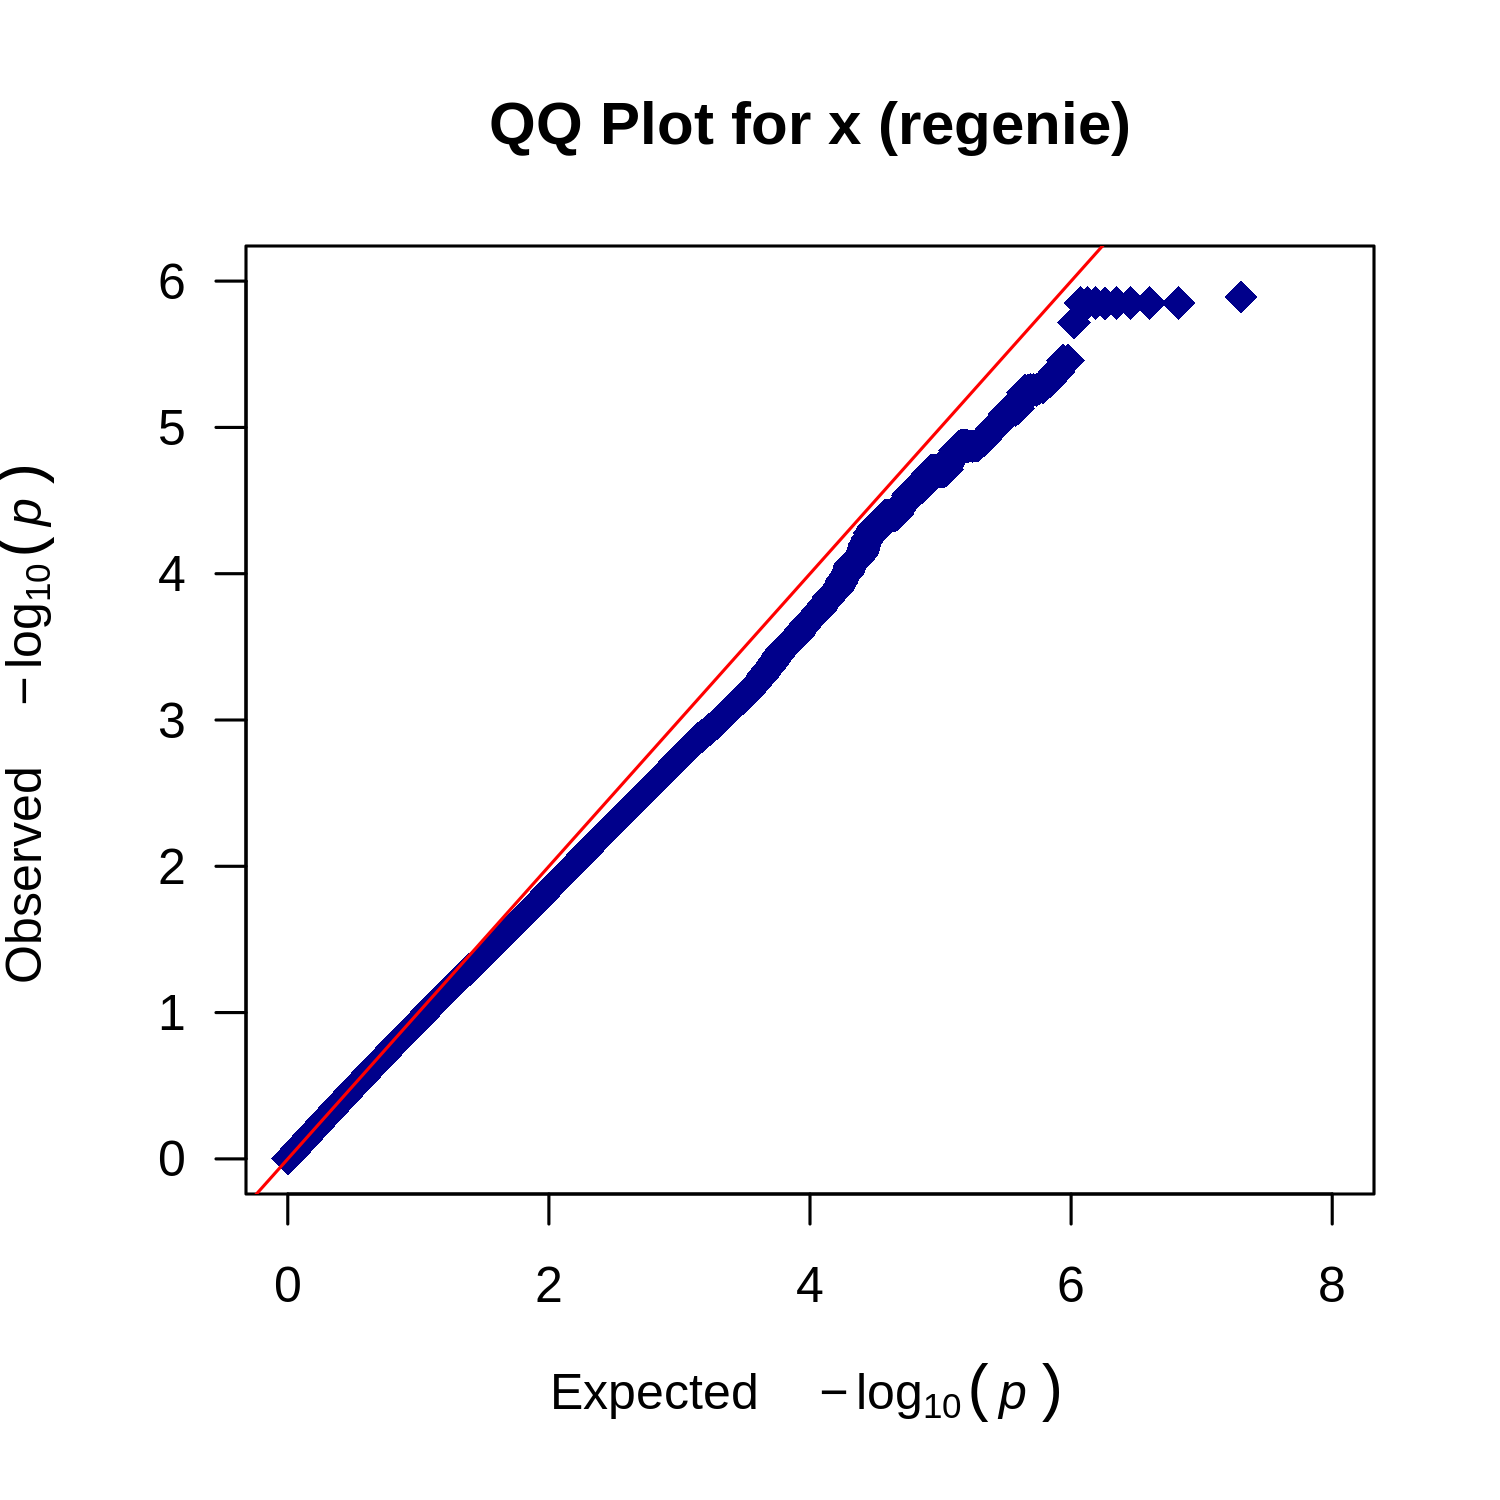

In [4]:
%preview -s png ~/MWE_regenie/1000G.EUR.pheno_x.regenie.qq.png

#### Lambda GC value

In [8]:
cat ~/MWE_regenie/1000G.EUR.pheno_x.regenie.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# x result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240

```
## p-value summary:
Genomic inflation factor is 0.943 for 9997231 variants analyzed.

---

# QQ plot for x

![](1000G.EUR.pheno_x.regenie.qq.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan_annotated.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan_annotated.svg)

---

# Result files
```
/home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.analysis_summary.md
/home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.log
/home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan.png
/home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan_annotated.pdf
/home/dmc2245/MWE_regenie/1000G.EUR.pheno_x.regenie.manhattan_annotated.png
/home/dmc2245/MWE_r

## Runing the burden test

Regenie offers the functionality of performing rare-variant aggregate association analysis in the form of burden tests.  

You can combine rare-variants in a gene or a region, using functional annotations to create masks that are then tested for association (as in a single variant analysis) with a phenotype. 

Input files:

1. You will need to provide an annotation file that is formatted: variant_id, gene/region, functional annotation (e.g. LoF, missense). You can use VEP or ANNOVAR to generate this information and then format it accordingly. 
2. Provide the set-list-file: this file contains a list of variants within each gene/region that's used when building the masks. The format is: gene/region name, chromosome, start_position, list of variants in the gene/region separated by comma. 
3. Optional: provide a file with genes/regions that you want to include or exclude from your analysis.
4. Optional: provide an allele-frequency file to use when creating the masks. By default the allele frequency is computed from the sample. In our case we are not providing a allele-frequency file, however in real life cases it is best to use allele frequencies obtained from an outside source such as gnomAD. 
5. Mask file: this is a text file that contains the name of the mask and the type of annotations to use when building it (one mask per line). E.g. 

```
mask1 LoF
mask2 LoF,missense
```

6. You need to provide the `--aaf-bins` cut-off in the parameters. This refers to the AAF upper bounds to use when creating the masks. By default regenie_burden produces results for singletons and if you set `--aaf-bins` to be for example 0.01 it will create masks from  [0,0.01] and singletons. 

Additionally, you can choose the way the mask are built among these options:
- using the maximum number of ALT alleles across sites ('max'; the default)
- using the sum of ALT alleles ('sum')
- using a maximum threshold of 2 ('comphet')

![Rules to build mask](https://rgcgithub.github.io/regenie/img/mask_rules.png)

### Generate annotation file

Note: verify the genomic coordinates specific to your genotype files. Our MWE has hg19 coordinate system, thefore we set the `--build` parameter to be `hg19`

In [9]:
annovar_dir=~/MWE_regenie/annotation 
bim_name=~/1000G_data/1000G.EUR.bim
annovar_sos=~/project/bioworkflows/variant-annotation/annovar.ipynb
annovar_sbatch=~/MWE_regenie/output/annovar_mwe1000G_EUR_$(date +"%Y-%m-%d").sbatch
job_size=1
humandb=/mnt/mfs/statgen/isabelle/REF/humandb
xref_path=/mnt/mfs/statgen/isabelle/REF/humandb
container_annovar=/mnt/mfs/statgen/containers/gatk4-annovar.sif
name_prefix=MWE_1000G_EUR_hg19
tpl_file=~/project/bioworkflows/admin/csg.yml
build='hg19'

# Use the bim_merge workflow first and then the annovar workflow
annovar_args="""annovar
    --cwd $annovar_dir \
    --bim_name $bim_name \
    --humandb $humandb \
    --xref_path $xref_path \
    --job_size $job_size \
    --build $build\
    --name_prefix $name_prefix \
    --container_annovar $container_annovar
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $annovar_sos \
    --to-script $annovar_sbatch \
    --args "$annovar_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/MWE_regenie/output/annovar_mwe1000G_EUR_2021-10-13.sbatch
INFO: Workflow csg (ID=w3446957268dec5ff) is executed successfully with 1 completed step.



### Create the files necessary for burden test

We have created in-house workflows that help us generate these files automatically, with the exception of the mask file, which is easily created using a text editor like `vim` or `nano`. The script below will allow us to generate the annotation and set list files. 

In [ ]:
#Get the column numbers 
zcat 1000G.EUR.hg19.hg19_multianno.csv.gz | head -1  | sed 's/,/\n/g' | nl
# Extract the necessary columns AF_nfe gnomAD exome
cat 1000G.EUR.hg19.hg19_multianno.csv |  awk -F "," '{print $1","$2","$3","$4","$5","$7","$9","$56","$75}' | sed 's/\"//g' | gzip -9 > 1000G.EUR.hg19.hg19_multianno_avsnp150.csv.gz
# Replace dot
cat 1000G.EUR.hg19.hg19_multianno.csv.aff_file | awk '{sub(/^.$/, "0.0", $2)}1' > 1000G.EUR.hg19.hg19_multianno.csv.replacedot.aff_file

In [ ]:
module load Singularity
sos run ~/project/bioworkflows/variant-annotation/annovar.ipynb burden_files\
    --cwd ~/MWE_regenie/annotation \
    --annotated_file ~/MWE_regenie/annotation/1000G.EUR.hg19.hg19_multianno.csv.gz\
    --bim_name ~/1000G_data/1000G.EUR.bim \
    --job_size 1 \
    --name_prefix mwe_regenie_burden \
    --rsid True\
    --container_lmm /mnt/mfs/statgen/containers/lmm.sif

### Regenie burden commands

In [ ]:
module load Singularity
sos run ~/project/bioworkflows/GWAS/LMM.ipynb regenie_burden \
    --cwd ~/MWE_regenie/output_diana2 \
    --bfile ~/1000G_data/1000G.EUR.filtered.pruned.bed \
    --maf-filter 0 \
    --geno-filter 0 \
    --mind-filter 0 \
    --hwe_filter 0 \
    --genoFile ~/MWE_regenie/data/1000G.EUR.bed \
    --phenoFile  ~/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/project/UKBB_GWAS_dev/data/regenie_template.yml\
    --phenoCol x\
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 1 \
    --reverse_log_p \
    --p-filter 1 \
    --label_annotate SNP\
    --anno_file ~/MWE_regenie/data/*.anno_file\
    --aaf_file ~/MWE_regenie/data/*.aff_file\
    --set_list ~/MWE_regenie/data/*.set_list_file\
    --mask_file ~/MWE_regenie/data/*.mask_file\
    --snpannofile ~/MWE_regenie/data/1000G.EUR.hg19.hg19_multianno_filtered.csv\
    --build_mask max\
    --aaf_bins  0.01\
    --container_lmm /mnt/mfs/statgen/containers/lmm.sif\
    --container_marp /mnt/mfs/statgen/containers/marp.sif\
    -e ignore

## Miniature example

In [ ]:
module load Singularity
sos run ~/project/UKBB_GWAS_dev/workflow/regenie.ipynb regenie_burden \
    --cwd ~/MWE_regenie/output_burden_test \
    --bfile /home/dmc2245/1000G_data/1000G.EUR.filtered.pruned.bed \
    --maf-filter 0 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile /home/dmc2245/1000G_data/1000G.EUR.filtered.pruned.bed \
    --phenoFile  ~/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/project/UKBB_GWAS_dev/data/regenie_template.yml\
    --phenoCol x\
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 1 \
    --reverse_log_p \
    --p-filter 1 \
    --anno_file ~/MWE_regenie/data/*.anno_file\
    --aaf_file ~/MWE_regenie/data/*.aff_file\
    --set_list ~/MWE_regenie/data/*.set_list_file\
    --mask_file ~/MWE_regenie/data/*.mask_file\
    --build_mask max\
    --aaf_bins  0.01\
    --container_lmm /mnt/mfs/statgen/containers/lmm.sif\
    --container_marp /mnt/mfs/statgen/containers/marp.sif\
    -e ignore

> /home/dmc2245/MWE_regenie/output_burden_test/1000G.EUR.pheno_x.regenie_burden.mask1.0.manhattan.png (180.7 KiB):

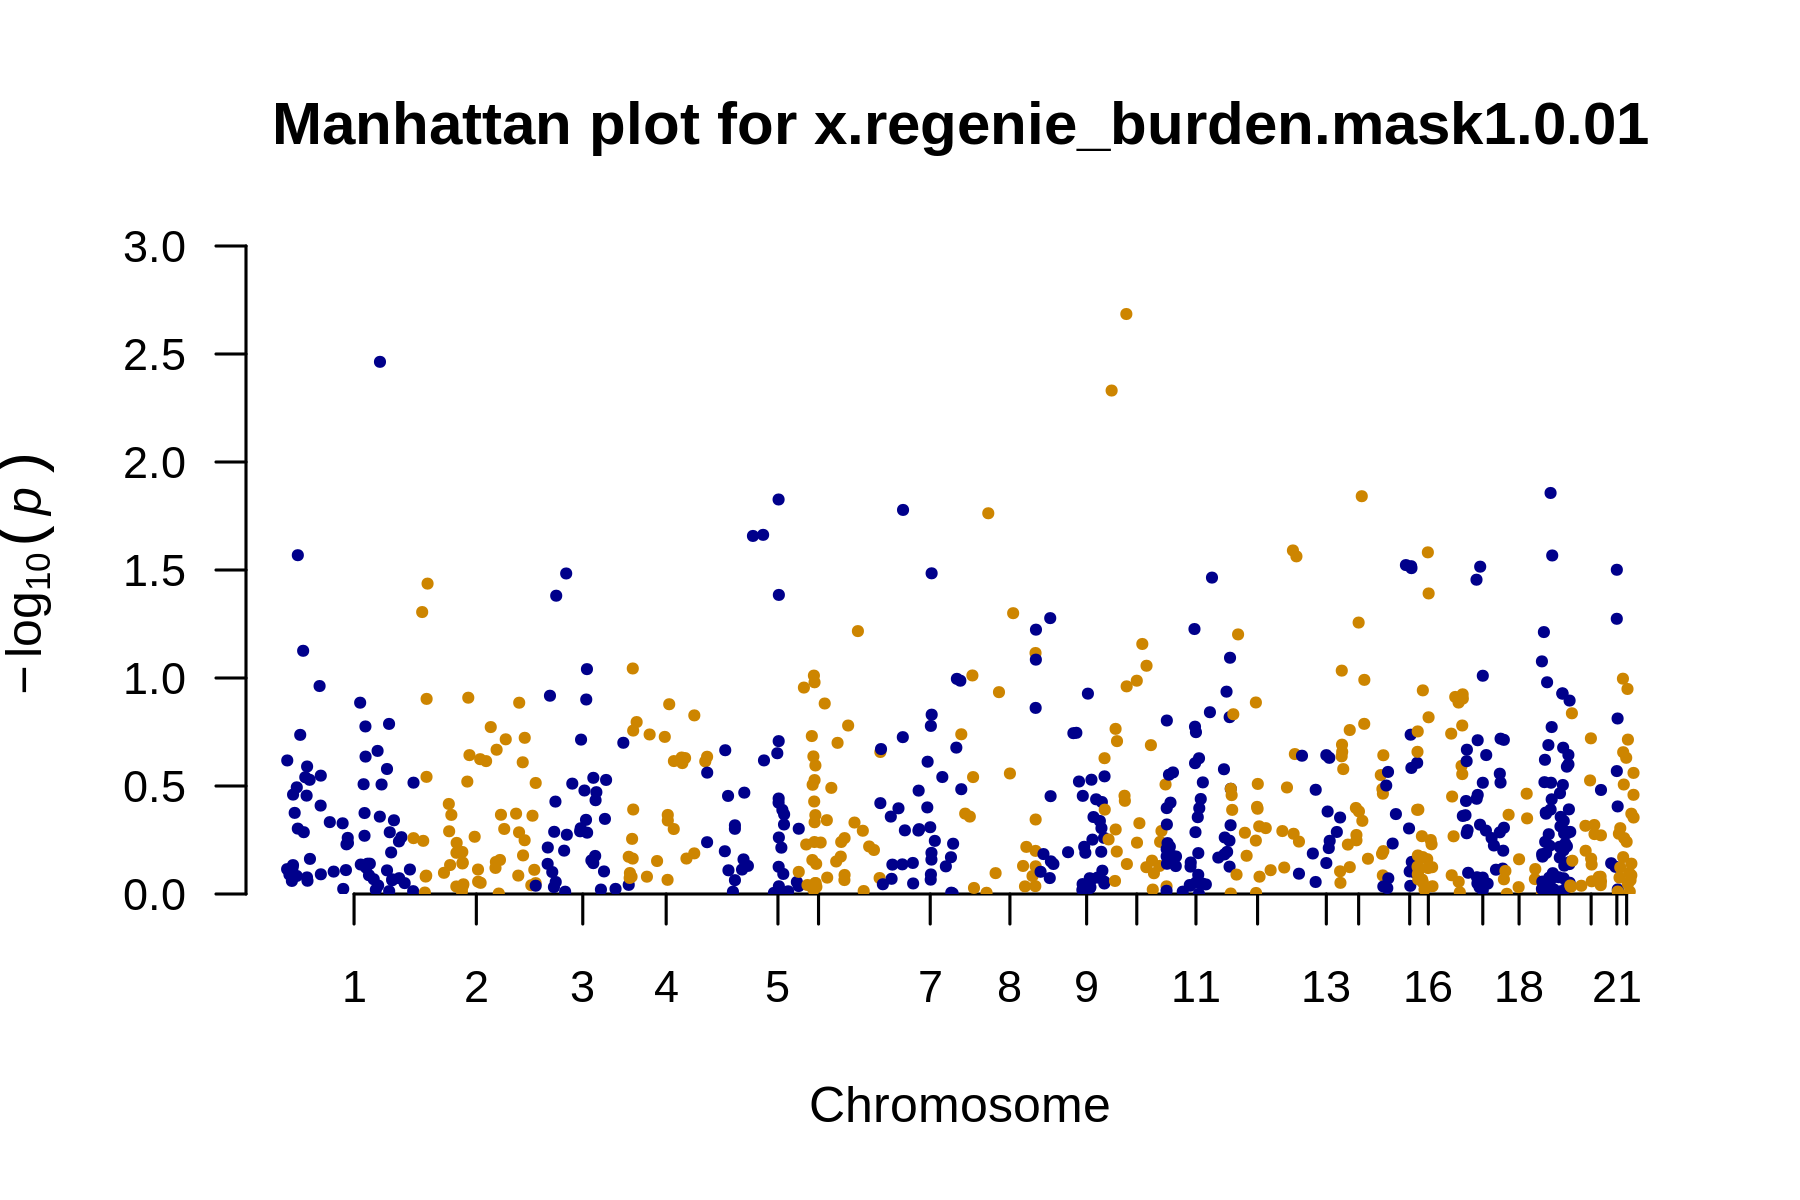

>>> /home/dmc2245/MWE_regenie/output_burden_test/1000G.EUR.pheno_x.regenie_burden.mask1.0.manhattan.png:

bash: /home/dmc2245/MWE_regenie/output_burden_test/1000G.EUR.pheno_x.regenie_burden.mask1.0.manhattan.png: Permission denied



In [3]:
%preview -s png /home/dmc2245/MWE_regenie/output_burden_test/1000G.EUR.pheno_x.regenie_burden.mask1.0.manhattan.png

### Add plots burden test and lambda

> /home/dmc2245/MWE_regenie/burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.5.manhattan.png (266.0 KiB):

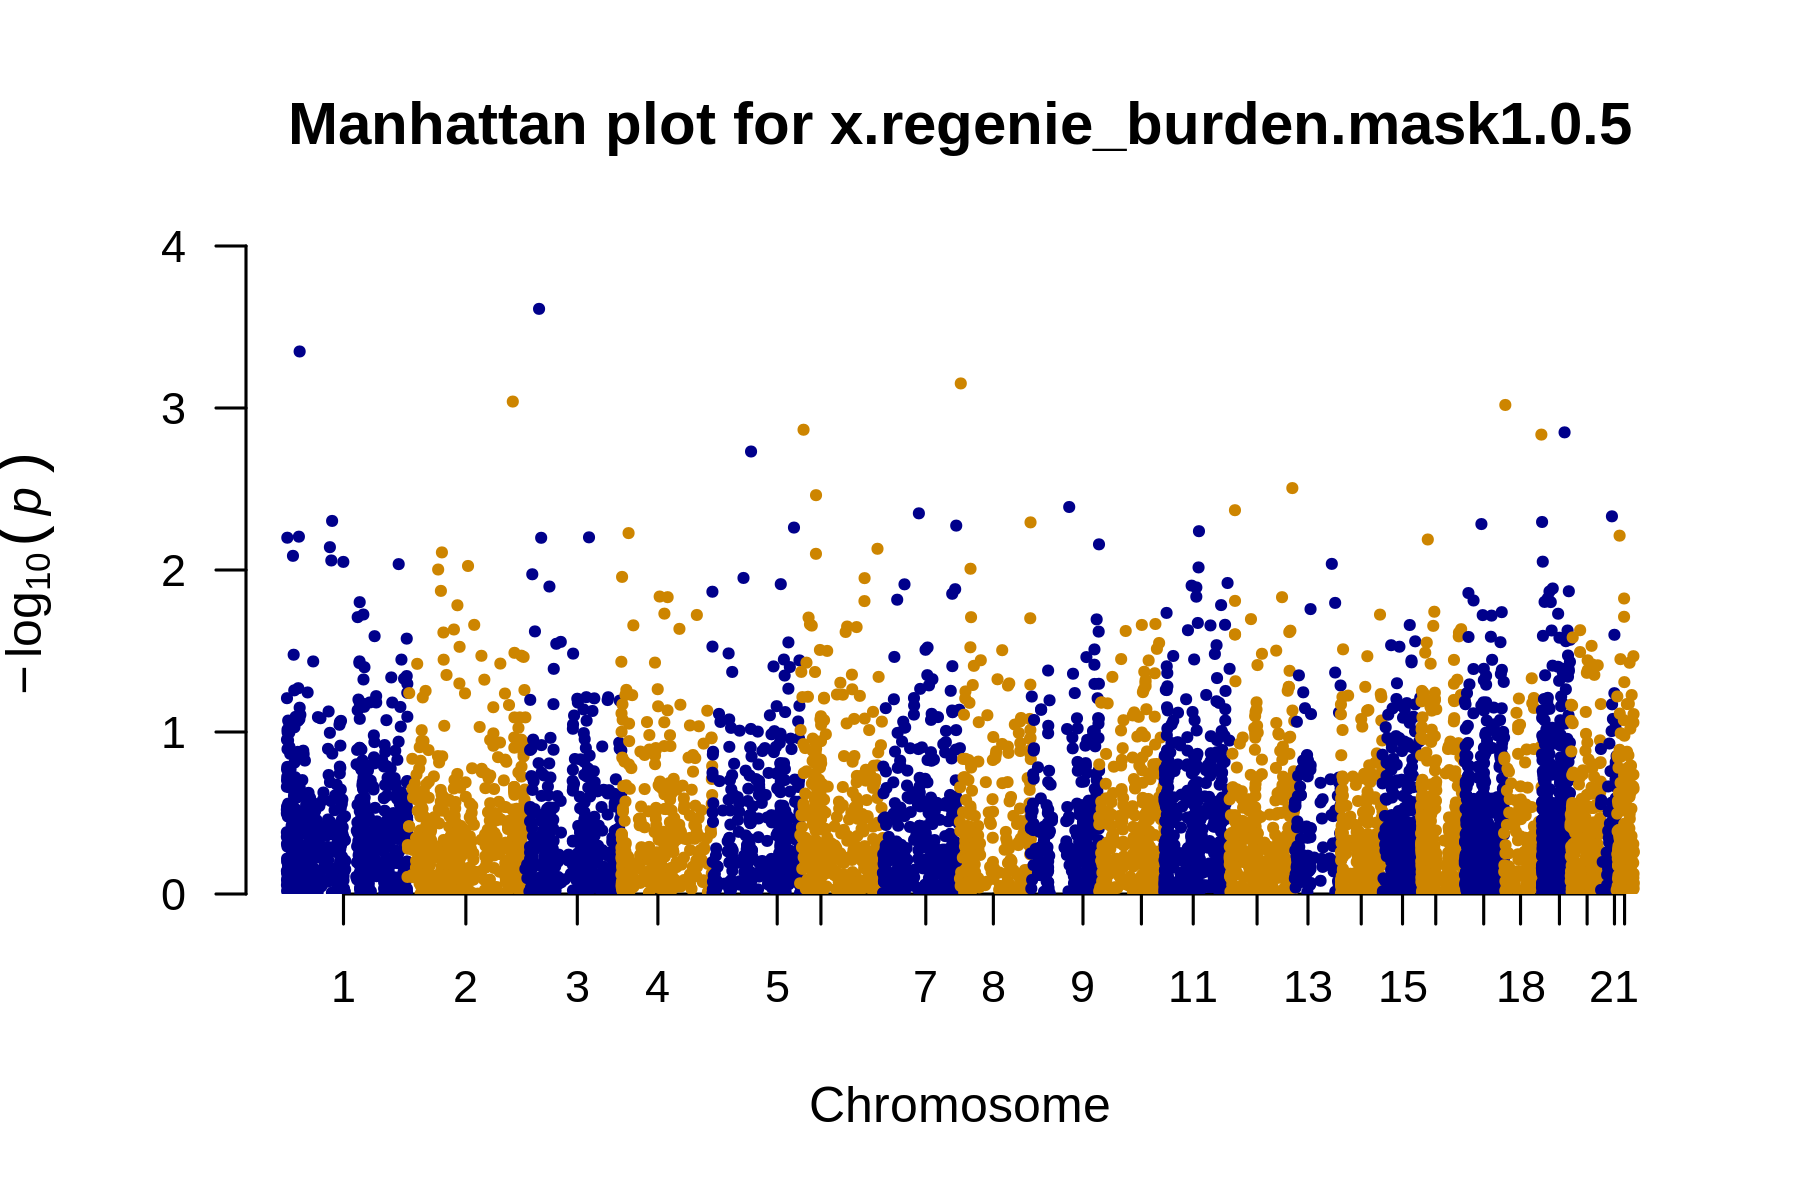

>>> ~/MWE_regenie/burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.5.manhattan.png:

bash: /home/dmc2245/MWE_regenie/burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.5.manhattan.png: Permission denied



In [2]:
%preview -s png ~/MWE_regenie/burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.5.manhattan.png